# Trung Hau Nguyen - 101445701

## Steps:
1. Download the road sign data: https://drive.google.com/file/d/1Tzw4hHHRIhkJpCeFye5kafD_Go7A4vNv/view
2. Data Analyzing
3. Adding more data to make balanced data
4. Load pretrained model (VGG16)
5. Adding finetuned layers
6. Train model
7. Test model.

## Importing libraries

In [1]:
import os

import random
import zipfile
from collections import Counter

import numpy as np
import pandas as pd

import cv2
from sklearn.model_selection import train_test_split

import keras
from keras.utils import to_categorical
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## Setup

In [2]:
# Upload dataset onto google Colab
# Extract dataset .zip file to colab
zip_file_path = "/content/dataset.zip"
extract_to_directory = "/content"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

## Prepare the data

In [3]:
path = "Main_focus_dataset"
labelFile = 'labels_8_signs.csv'

In [4]:
count = 0
images = []
signNo = []
myList = os.listdir(path)
myList.remove(".DS_Store")

In [5]:
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)

Total Classes Detected: 8


In [6]:
print("Importing Classes.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        if y == ".DS_Store":
            pass
        else:
            images.append(curImg)
            signNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")

Importing Classes.....
0 1 2 3 4 5 6 7  


In [7]:
# Read .csv to map meaningful labels for the dataset
labels_df = pd.read_csv(labelFile)
sign_mapping = dict(zip(labels_df['ClassId'], labels_df['Name']))
sign_label = [sign_mapping[sign_num] for sign_num in signNo]

In [8]:
values_list = list(sign_mapping.values())
print("List of classes:", values_list)

List of classes: ['Speed limit (60km/h)', 'Speed limit (80km/h)', 'No passing', 'Yield', 'Stop', 'No vehiles', 'No entry', 'Road work']


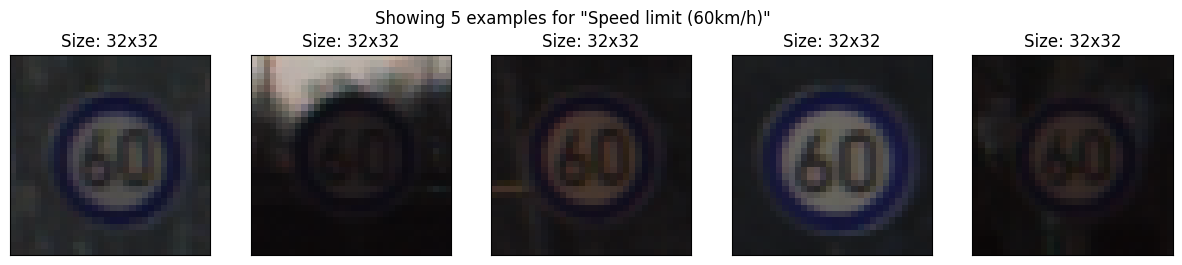

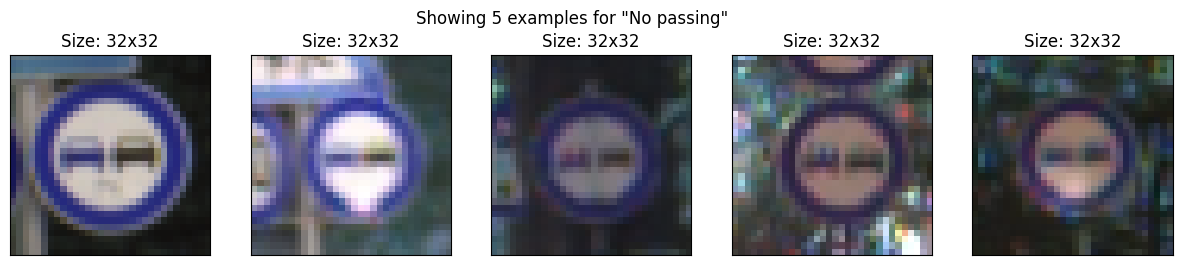

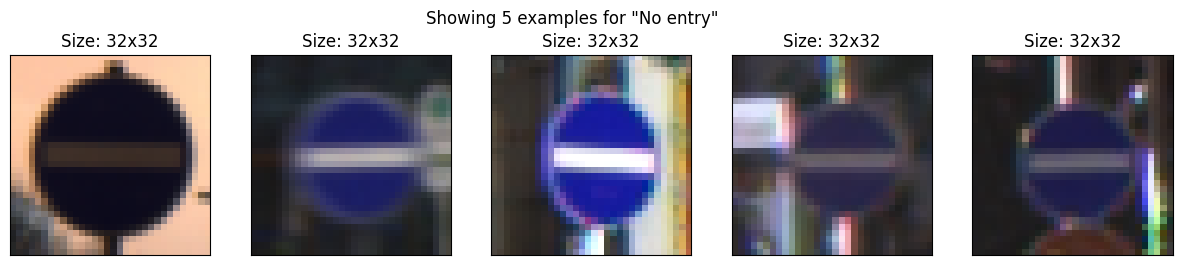

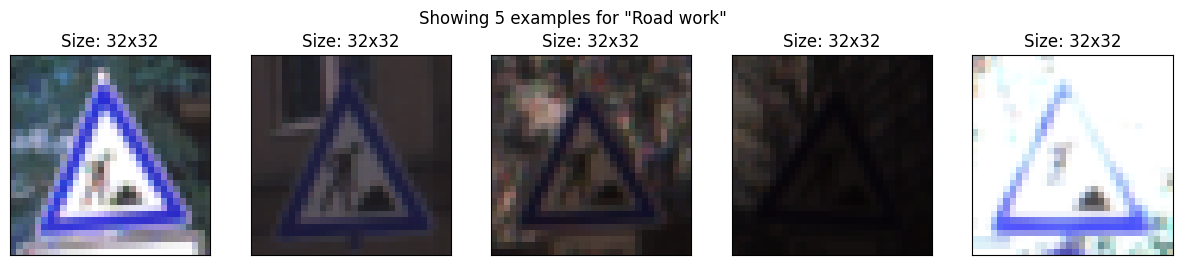

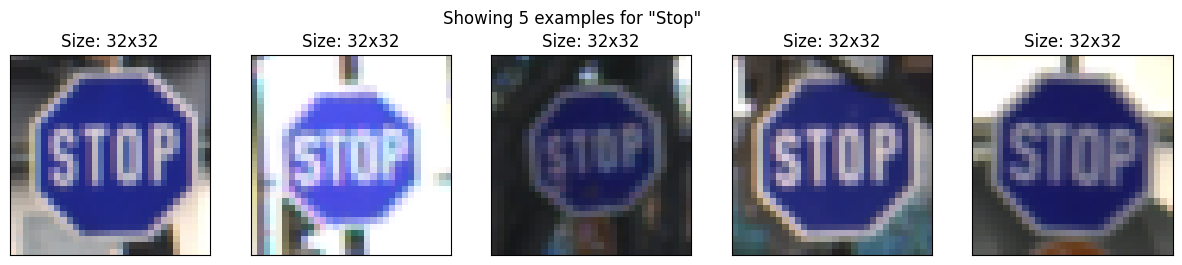

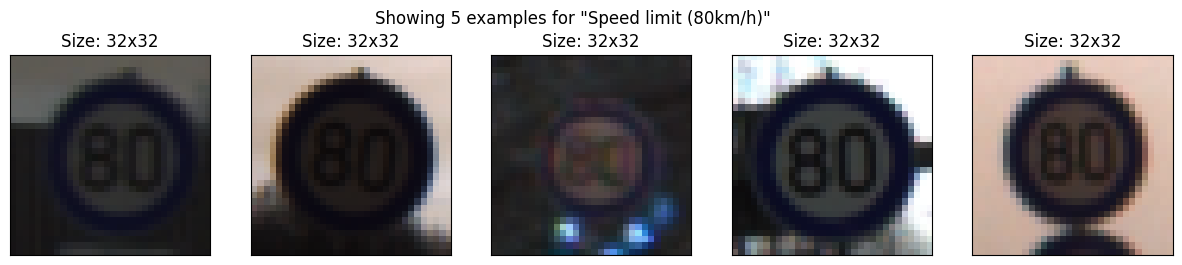

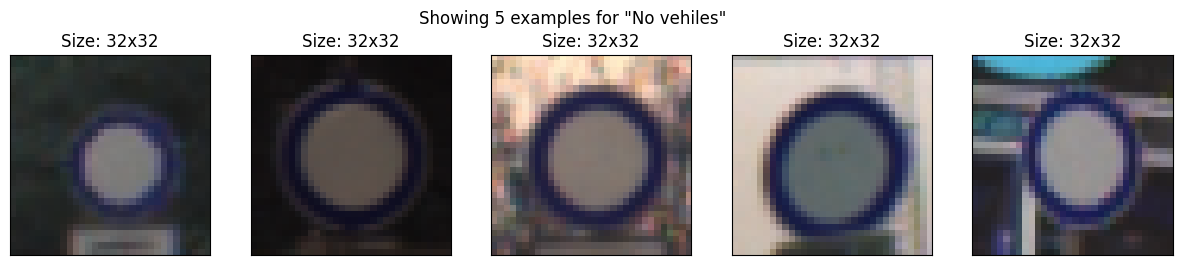

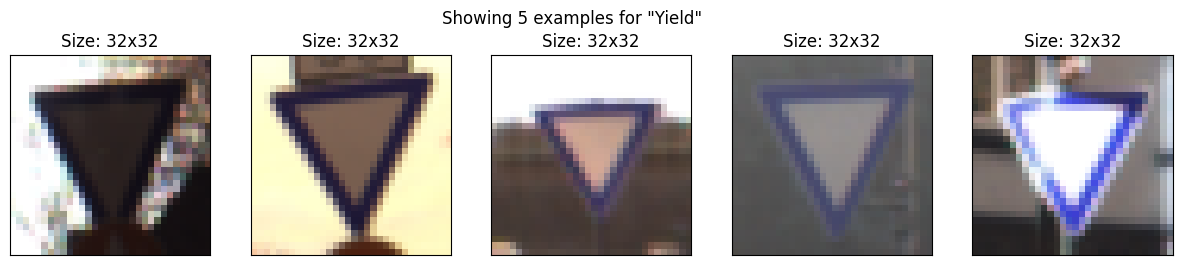

In [9]:
# Get the list of labels from the list of folder names.
exampleNo = 5
labels = []
for i in os.listdir(path):
  if os.path.isdir(os.path.join(path, i)):
    labels.append(i)

# Show the images.
for label in labels:
  label_dir = os.path.join(path, label)
  example_filenames = os.listdir(label_dir)[:exampleNo]
  fig, axs = plt.subplots(1, exampleNo, figsize=(15, 3))
  for i in range(exampleNo):
    img = plt.imread(os.path.join(label_dir, example_filenames[i]))
    height, width, _ = img.shape
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    axs[i].set_title(f'Size: {width}x{height}')
  fig.suptitle(f'Showing {exampleNo} examples for "{values_list[int(label)]}"')

plt.show()

In [10]:
num_classes = 8
input_shape = (32, 32, 3)

### Check labels and if the dataset is balance or not

In [11]:
# Count the occurrences of each record
record_counts = Counter(sign_label)

print("Number of records for each sign:")

num_of_record = []
for record, count in record_counts.items():
    print(f"{record}: {count} images")
    num_of_record.append(count)

Number of records for each sign:
Speed limit (60km/h): 1260 images
Speed limit (80km/h): 1650 images
No passing: 1320 images
Yield: 1920 images
Stop: 690 images
No vehiles: 540 images
No entry: 990 images
Road work: 1350 images


#### -> Imbalanced dataset

### Add more data

In [12]:
def random_flip(image):
    flip_image = cv2.flip(image, 1)
    return flip_image

def random_rotate(image):
    rows, cols, _ = image.shape
    angle = random.choice([-45, -20, -10, 10, 20, 45])
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    return rotated_image

def random_zoom(image):
    zoom_factor = random.uniform(0.8, 1.2)
    zoomed_image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor)
    return zoomed_image

def random_brightness(image, brightness_range=(0.5, 1.5)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    brightness_factor = random.uniform(*brightness_range)
    hsv[:,:,2] = np.clip(hsv[:,:,2] * brightness_factor, 0, 255)
    brightened_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return brightened_image

def random_contrast(image, contrast_range=(0.5, 1.5)):
    contrast_factor = random.uniform(*contrast_range)
    adjusted_image = cv2.convertScaleAbs(image, alpha=contrast_factor, beta=0)
    return adjusted_image



In [13]:
def random_augmentation_function(image):
    augmentation_functions = [random_rotate, random_flip, random_zoom, random_brightness, random_contrast]
    chosen_function = random.choice(augmentation_functions)
    if chosen_function == random_rotate:
        return random_rotate(image)
    elif chosen_function == random_flip:
        return random_flip(image)
    elif chosen_function == random_zoom:
        return random_zoom(image)
    elif chosen_function == random_brightness:
        return random_brightness(image)
    else:
        return random_contrast(image)

In [14]:
def save_augmented_image(image, save_path, index):
    filename = f"z_{index}.png"
    cv2.imwrite(os.path.join(save_path, filename), image)

### Check if the dataset is balance or not

In [15]:
path = "Main_focus_dataset"
labelFile = 'labels_8_signs.csv'

In [16]:
count = 0
pic_new_index = 0
# Create a dictionary to hold lists
lists = {}

images = []
labelNo = []
myList = os.listdir(path)
myList.remove(".DS_Store")
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)

Total Classes Detected: 8


In [17]:
print("Importing Classes.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))

    # Create the lists for each objects
    lists[f'list_{count}'] = []
    lists[f'list_{count}_augmentation'] = []

    while(len(lists[f'list_{count}']) + len(lists[f'list_{count}_augmentation']) < 2000):
        for y in myPicList:
            curImg = cv2.imread(path+"/"+str(count)+"/"+y)
            if y == ".DS_Store":
                pass
            else:
                augmented_image = random_augmentation_function(curImg)
                save_augmented_image(augmented_image, path+"/"+str(count), pic_new_index)
                lists[f'list_{count}'].append(curImg)
                lists[f'list_{count}_augmentation'].append(augmented_image)
            pic_new_index += 1

    pic_new_index = 0

    number_index_drop = len(lists[f'list_{count}']) + len(lists[f'list_{count}_augmentation']) - 2000 # goal is take 2000 images for each object

    lists[f'list_{count}_augmentation'] = lists[f'list_{count}_augmentation'][:-number_index_drop] # drop images which are out of 2000 images
    lists[f'list_{count}'] += lists[f'list_{count}_augmentation']
    images += lists[f'list_{count}'] # create another list to contain all images

    label_count = [count] * len(lists[f'list_{count}'])
    labelNo += label_count # create the label list to contain all labels

    print(count, end =" ")
    count +=1
print(" ")

Importing Classes.....
0 1 2 3 4 5 6 7  


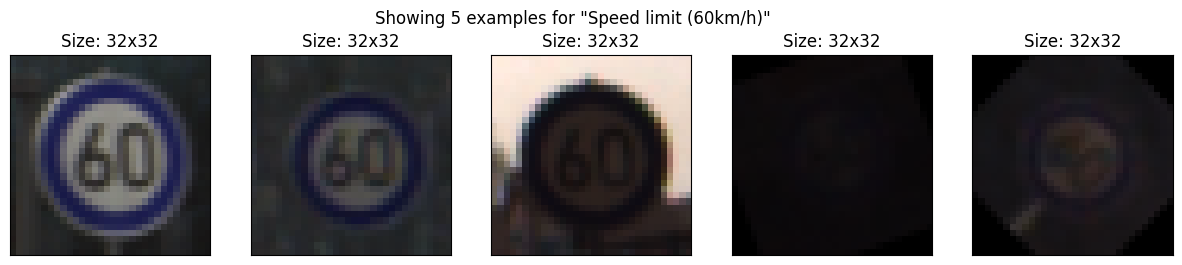

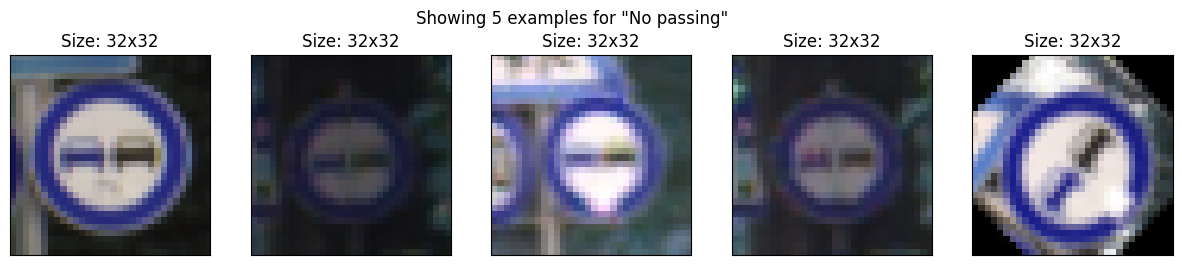

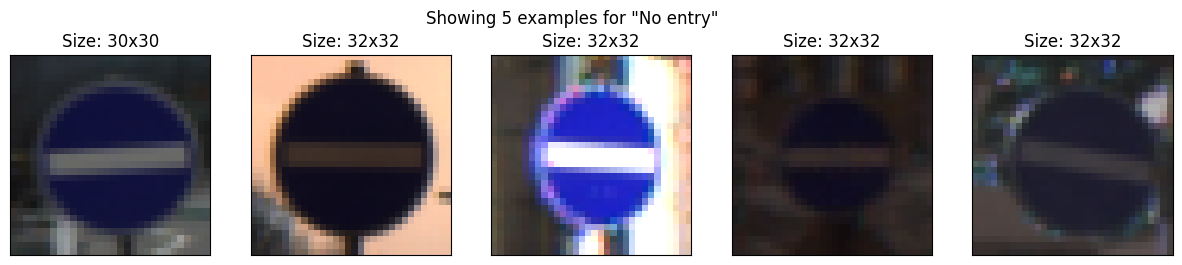

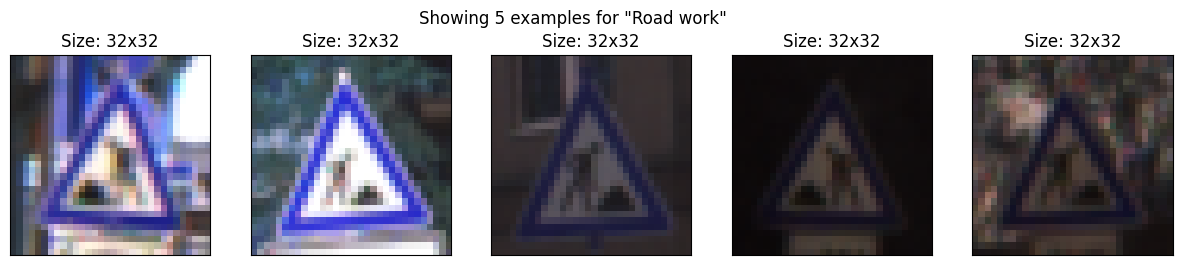

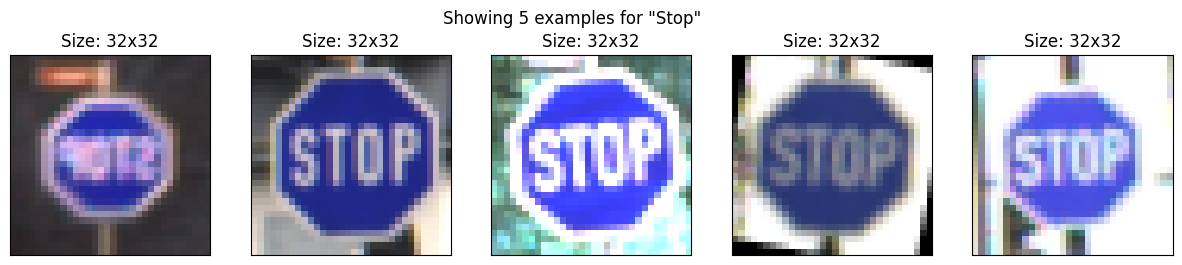

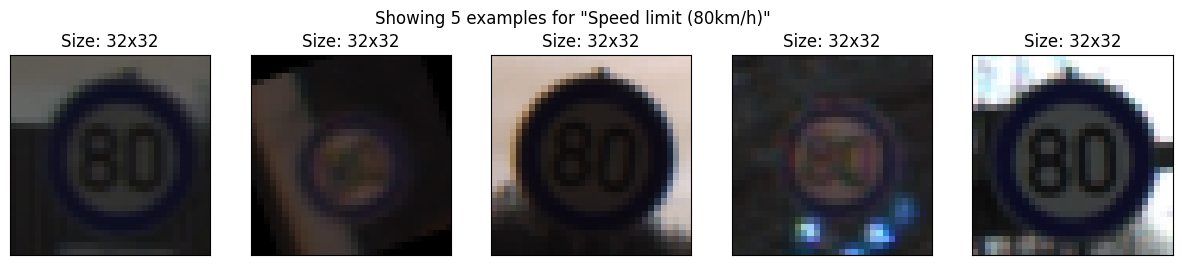

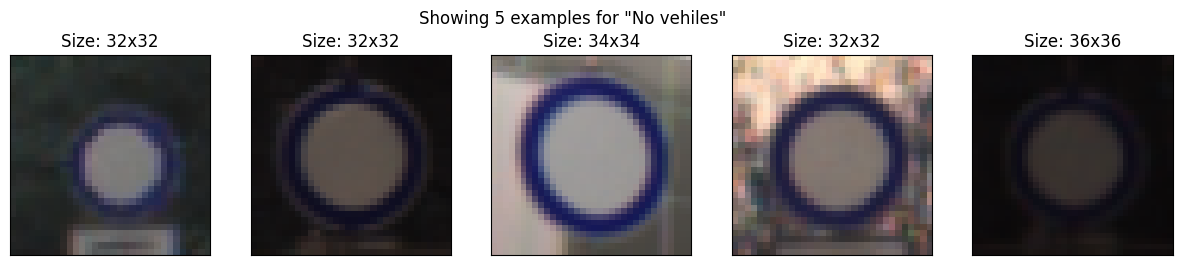

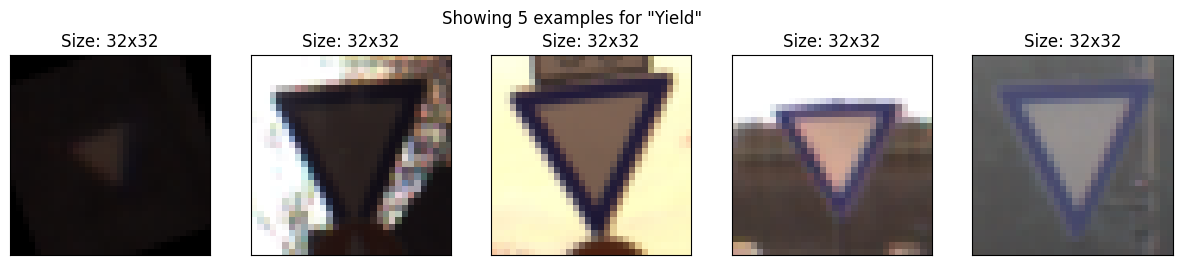

In [18]:
# Get the list of labels from the list of folder names.
exampleNo = 5
labels = []
for i in os.listdir(path):
  if os.path.isdir(os.path.join(path, i)):
    labels.append(i)

# Show the images.
for label in labels:
  label_dir = os.path.join(path, label)
  example_filenames = os.listdir(label_dir)[:exampleNo]
  fig, axs = plt.subplots(1, exampleNo, figsize=(15, 3))
  for i in range(exampleNo):
    img = plt.imread(os.path.join(label_dir, example_filenames[i]))
    height, width, _ = img.shape
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    axs[i].set_title(f'Size: {width}x{height}')
  fig.suptitle(f'Showing {exampleNo} examples for "{values_list[int(label)]}"')

plt.show()

In [19]:
len(images) # total images on the dataset now

16000

In [20]:
# Read .csv to map meaningful labels for the dataset
labels_df = pd.read_csv(labelFile)
sign_mapping = dict(zip(labels_df['ClassId'], labels_df['Name']))
sign_label = [sign_mapping[sign_num] for sign_num in labelNo]

In [21]:
# Count the occurrences of each record
record_counts = Counter(sign_label)

print("Number of records for each sign:")

num_of_record = []
for record, count in record_counts.items():
    print(f"{record}: {count} images")
    num_of_record.append(count)

Number of records for each sign:
Speed limit (60km/h): 2000 images
Speed limit (80km/h): 2000 images
No passing: 2000 images
Yield: 2000 images
Stop: 2000 images
No vehiles: 2000 images
No entry: 2000 images
Road work: 2000 images


#### -> balanced dataset with 2000 images for each object

## Shuffle and split the dataset

In [22]:
# Split the data into training, testing and validating (70|15|15)
x_train, x_test_temp, y_train, y_test_temp = train_test_split(images,
                                                              labelNo,
                                                              test_size=0.3,
                                                              random_state=10,
                                                              stratify=labelNo)

x_val, x_test, y_val, y_test = train_test_split(x_test_temp,
                                                y_test_temp,
                                                test_size=0.5,
                                                random_state=10,
                                                stratify=y_test_temp)

# Print the sizes of the resulting sets
print("Training set size:", len(x_train))
print("Validation set size:", len(x_val))
print("Test set size:", len(x_test))


Training set size: 11200
Validation set size: 2400
Test set size: 2400


## Resize the dataset

In [23]:
def check_image_size(images):
    count = 0
    for i, image in enumerate(images):
        height, width, _ = image.shape
        if height != 32 or width != 32: # check if any image has different size of 32x32 or not
            count += 1
    return count

num_incorrect_size = check_image_size(x_train)
print("Number of images with incorrect size:", num_incorrect_size)

Number of images with incorrect size: 482


In [24]:
def resized_image(images): # develop a function to resize the image which is not same size as input image
    desired_width = 32
    desired_height = 32

    # Resize all images
    resized = []
    for image in images:
        resized_image_list = cv2.resize(image, (desired_width, desired_height))
        resized.append(resized_image_list)
    return np.array(resized)

In [25]:
x_train = resized_image(x_train)
x_test = resized_image(x_test)
x_val = resized_image(x_val)

In [26]:
# Convert class labels to one-hot encode format
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

## Load VGG16

In [27]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [28]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [29]:
conv_base.trainable = False # freeze the layers
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Adding layers and finetuning VGG16

In [30]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 tf.__operators__.getitem (  (None, 32, 32, 3)         0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 32, 32, 3)         0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0     

## Training

In [32]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Fit the model
history = model.fit(
    x_train, y_train_one_hot,
    epochs=50,
    validation_data=(x_val, y_val_one_hot)
)

Epoch 1/50
350/350 [==============================] - 9s 13ms/step - loss: 4.8854 - accuracy: 0.7612 - val_loss: 1.1442 - val_accuracy: 0.8850
Epoch 2/50
350/350 [==============================] - 4s 10ms/step - loss: 1.9460 - accuracy: 0.8512 - val_loss: 0.8085 - val_accuracy: 0.9038
Epoch 3/50
350/350 [==============================] - 4s 11ms/step - loss: 1.4096 - accuracy: 0.8639 - val_loss: 0.6606 - val_accuracy: 0.9013
Epoch 4/50
350/350 [==============================] - 4s 11ms/step - loss: 0.9397 - accuracy: 0.8786 - val_loss: 0.4662 - val_accuracy: 0.9008
Epoch 5/50
350/350 [==============================] - 4s 10ms/step - loss: 0.7445 - accuracy: 0.8803 - val_loss: 0.3872 - val_accuracy: 0.9150
Epoch 6/50
350/350 [==============================] - 4s 11ms/step - loss: 0.7312 - accuracy: 0.8779 - val_loss: 0.4448 - val_accuracy: 0.8963
Epoch 7/50
350/350 [==============================] - 4s 11ms/step - loss: 0.6993 - accuracy: 0.8813 - val_loss: 0.5129 - val_accuracy: 0.9029

In [33]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

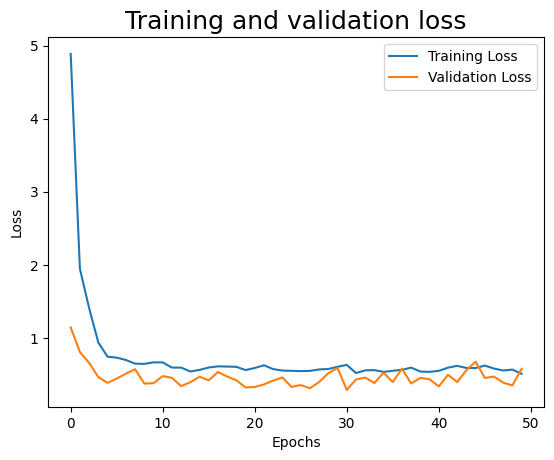

In [34]:
# Plot training and validation loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training and validation loss",fontsize=18)
plt.show()

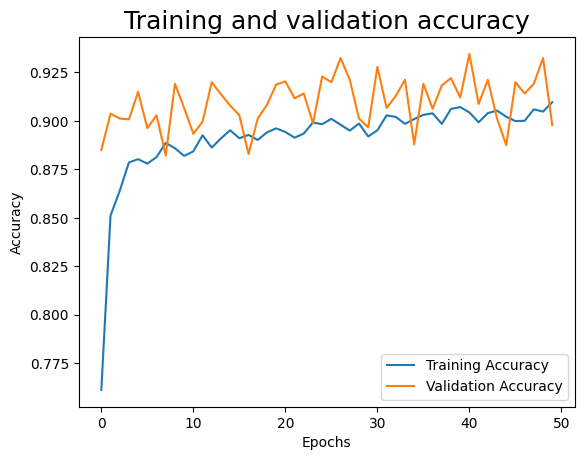

In [35]:
# Plot training and validation loss
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training and validation accuracy",fontsize=18)
plt.show()

In [36]:
score = model.evaluate(x_test, y_test_one_hot, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.7282642722129822
Test accuracy: 0.8945833444595337


## Teting some sign picutures

### Stop sign

In [37]:
class_mapping = {
    "Speed limit (60km/h)": 0,
    "Speed limit (80km/h)": 1,
    "No passing": 2,
    "Yield": 3,
    "Stop": 4,
    "No vehiles": 5,
    "No entry": 6,
    "Road work": 7,
}

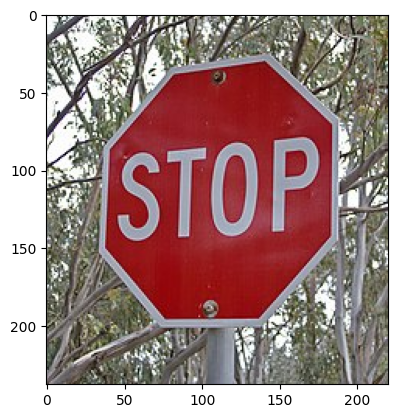

In [39]:
image_path = "sign1.jpg"
new_image = cv2.imread(image_path)
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)

plt.imshow(new_image, cmap='gray')
plt.show()

In [40]:
target_width = 32
target_height = 32
resized_image = cv2.resize(new_image, (target_width, target_height))

preprocessed_image = keras.applications.vgg16.preprocess_input(resized_image)
input_image = np.expand_dims(preprocessed_image, axis=0)

In [41]:
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)

1/1 [==============================] - 1s 731ms/step


In [42]:
predicted_class = [key for key, value in class_mapping.items() if value == predicted_class][0]
print("Predicted sign:", predicted_class)

Predicted sign: Stop


### Yield sign

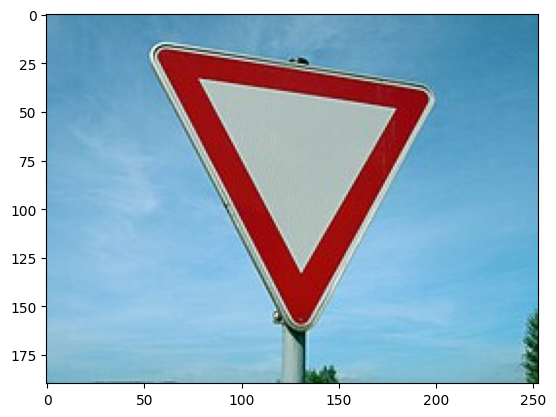

In [43]:
image_path = "sign2.jpg"
new_image = cv2.imread(image_path)
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)

plt.imshow(new_image, cmap='gray')
plt.show()

In [44]:
resized_image = cv2.resize(new_image, (target_width, target_height))

preprocessed_image = keras.applications.vgg16.preprocess_input(resized_image)
input_image = np.expand_dims(preprocessed_image, axis=0)

predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)

predicted_class = [key for key, value in class_mapping.items() if value == predicted_class][0]
print("Predicted sign:", predicted_class)

1/1 [==============================] - 0s 98ms/step
Predicted sign: Yield


### Limit speed sign

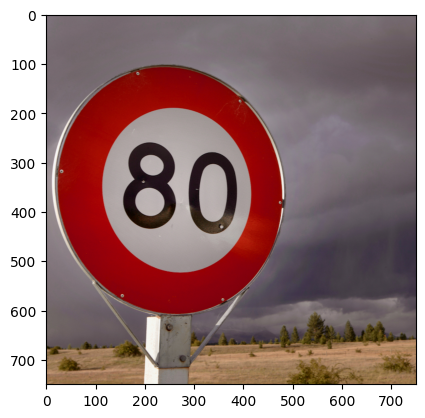

In [55]:
image_path = "sign3.jpeg"
new_image = cv2.imread(image_path)
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)

plt.imshow(new_image, cmap='gray')
plt.show()

In [56]:
resized_image = cv2.resize(new_image, (target_width, target_height))

preprocessed_image = keras.applications.vgg16.preprocess_input(resized_image)
input_image = np.expand_dims(preprocessed_image, axis=0)

predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)

predicted_class = [key for key, value in class_mapping.items() if value == predicted_class][0]
print("Predicted sign:", predicted_class)

1/1 [==============================] - 0s 30ms/step
Predicted sign: Speed limit (80km/h)
